In [27]:
import numpy as np
import autograd.numpy as anp
from autograd import grad, jacobian
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import dates
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *
from src.helpers import future_prediction
from src.plotting_utils import *
from tqdm import tqdm
import ipywidgets as widgets

### Plotting Specifications

In [2]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})

In [3]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [4]:
from tueplots import figsizes
figsize_config = figsizes.neurips2021(nrows=2, ncols=3)
plt.rcParams.update(figsize_config)

In [5]:
plt.rcParams['figure.figsize']

[5.5, 2.266124625416281]

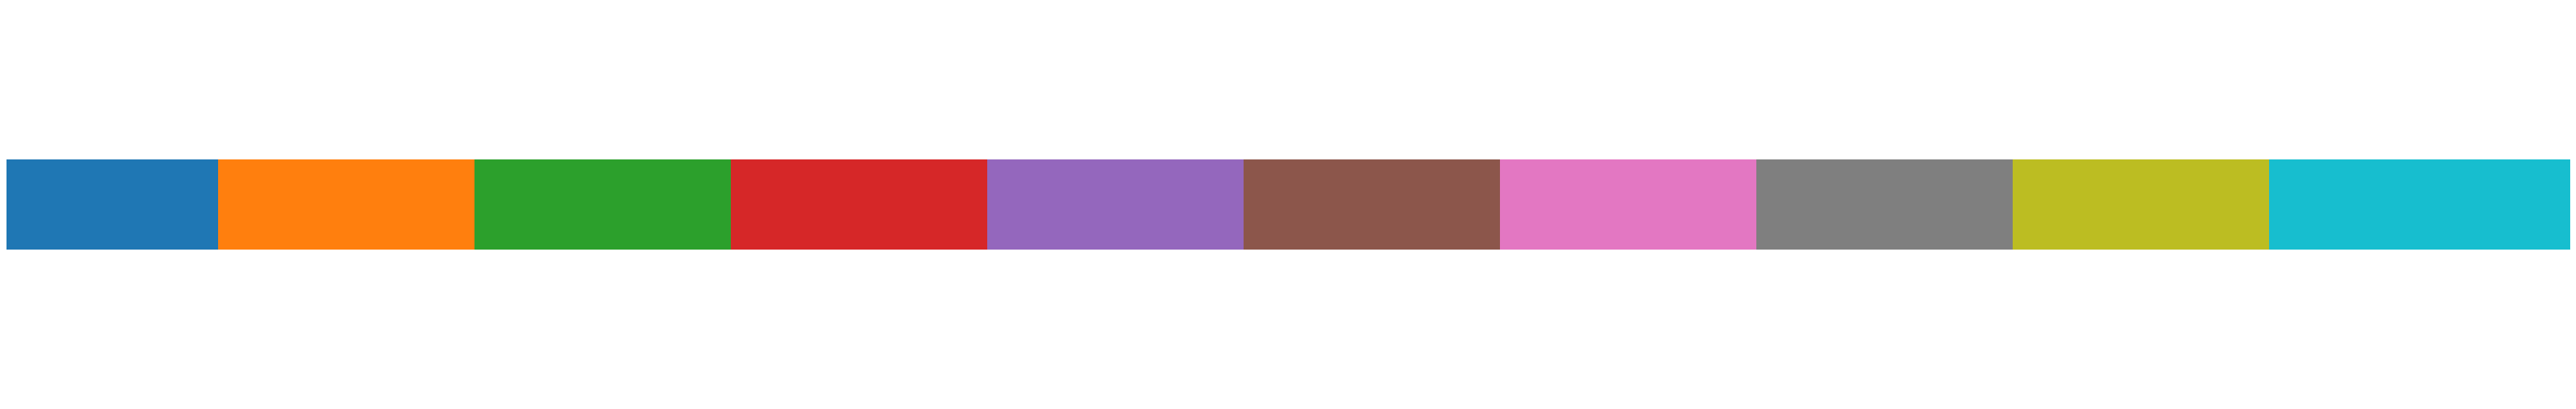

In [6]:
from cycler import cycler

# Get the color cycle from rcParams
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

# Visualize the colors
fig, ax = plt.subplots(figsize=(6, 1))
for i, color in enumerate(colors):
    ax.plot([i, i+1], [1, 1], color=color, linewidth=15)
ax.set_xlim(0, len(colors))
ax.set_ylim(0.5, 1.5)
ax.axis('off')
plt.show()

### Covid data with SIR model

In [7]:
# Data loading 
data = np.load("data_info.npz")
S = data["sird_data"][:, 0] / 1000
I = data["sird_data"][:, 1] / 1000
R = (data["sird_data"][:, 2] + data["sird_data"][:, 3]) / 1000

data_grid = np.array(data["data_grid"], dtype=int)
# print(data["date_range_x"].shape)
data_dates = data["date_range_x"][data_grid]

S = S[data_grid]
I = I[data_grid]
R = R[data_grid]

### Hyperparameters

In [8]:
# hyperparameters
beta_0 = 0.22
std_beta_0 = 0.01
std_beta_0_prime = 0.01
std_beta_0_prime_prime = 0.01

gamma=0.06 # this at the moment is acutally the recovery+the death rate in one

sigma_x = 0.00001 #this is the ouput scale at the moment for all S, I, R,
sigma_beta = 0.0003 #output scale for beta

std_R_I = 0.0005 #this is the observation uncertainty at the moment for the whole pde info and conservation
std_R_x = 0.01*0.0005 #this is the uncertainty in observing the infected count

In [9]:
#define the ODE x_dot = f(x)
Pop=S[0]+I[0]+R[0]


def vf(x):
    return anp.array([
        -1 * x[3]*x[0]*x[1],
        x[3]*x[0]*x[1] - gamma*x[1],
        gamma*x[1],
        0
    ])

#define the initial value
y0 = anp.array([S[0], I[0], R[0], beta_0])

#set dimenisons
d, q = 4, 2

#Prior model for q=2 TODO: generalize this for variable q
A = lambda h: anp.array([[1.0, h, h**2/2.0], [0.0, 1.0, h], [0.0, 0.0, 1.0]])
Q = lambda h: anp.array([[h**5/20.0, h**4/8.0, h**3/6.0],
                                    [h**4/8.0, h**3/3.0, h**2/2.0],
                                    [h**3/6.0, h**2/2.0, h]])

# Taylor-mode init via autograd for q=2
Jvf = jacobian(vf)
x1 = vf(y0)
x2 = anp.dot(Jvf(y0), x1)  # second derivative
#print(x2,Jvf(y0)@x1)
mu_0 = anp.concatenate([y0, x1, x2])  # shape (d*(q+1),)
#mu_0 = np.concat([y0, vf(y0), np.zeros(d)])
Sigma_0 = anp.eye(d*(q+1)) * 0.0
Sigma_0[3,3]=1. * std_beta_0
Sigma_0[7,7]=1. * std_beta_0_prime
Sigma_0[11,11]=1. * std_beta_0_prime_prime

# Discretization
t0, t1 = data_grid[0], data_grid[-1]
N = data_grid.shape[0] - 1
h = (t1 - t0) / N

# Constant step consequences
A_h =  anp.kron(A(h), anp.eye(d))
Q_h = anp.kron(Q(h), anp.diag([sigma_x, sigma_x, sigma_x, sigma_beta])**2)
b_h = anp.zeros((q+1)*d)
R_h = anp.eye(d)

#valid projections for q=2, TODO: generalize for variable q
E0 = anp.array([1., 0., 0.])
E1 = anp.array([0., 1., 0.])
E0 = anp.kron(E0, anp.eye(d))
E1 = anp.kron(E1, anp.eye(d))

# Measurement operator: x_dot - f(x) = 0
def g_conserved(X):
    #normnal measurement 
    x = anp.dot(E0, X)
    x_dot = anp.dot(E1, X)
    z_ode = x_dot - vf(x)
    #conservation
    z_conserved = anp.array([Pop-anp.sum(x[:3])])
    #Actual observation of Infected persons
    z_observation = anp.array([x[1]])

    return anp.concatenate([z_ode[:3], z_conserved, z_observation])

jacobian_g_conserved = jacobian(g_conserved)
z_sequence_conserved = anp.zeros((N, d+1))
z_sequence_conserved[:,-1] = I[1:]

R_h_conserved = anp.eye(d+1)
R_h_conserved[-1,-1] = std_R_I
R_h_conserved[:4, :4] *= std_R_x

assert jacobian_g_conserved(mu_0).shape == (d+1, 3*d), f"Unexpected shape: {jacobian_g_conserved(mu_0).shape}"

In [10]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward_stable(mu_0, Sigma_0, A_h, b_h, Q_h, R_h_conserved, g_conserved, jacobian_g_conserved, z_sequence_conserved, N)

m_sequence, P_sequence = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

In [11]:
political_events = [
    np.datetime64("2020-03-22"),
    np.datetime64("2020-05-06"),
    np.datetime64("2020-10-07"),
    np.datetime64("2020-11-02"),
    np.datetime64("2020-12-16"),
    np.datetime64("2021-04-23"),
]

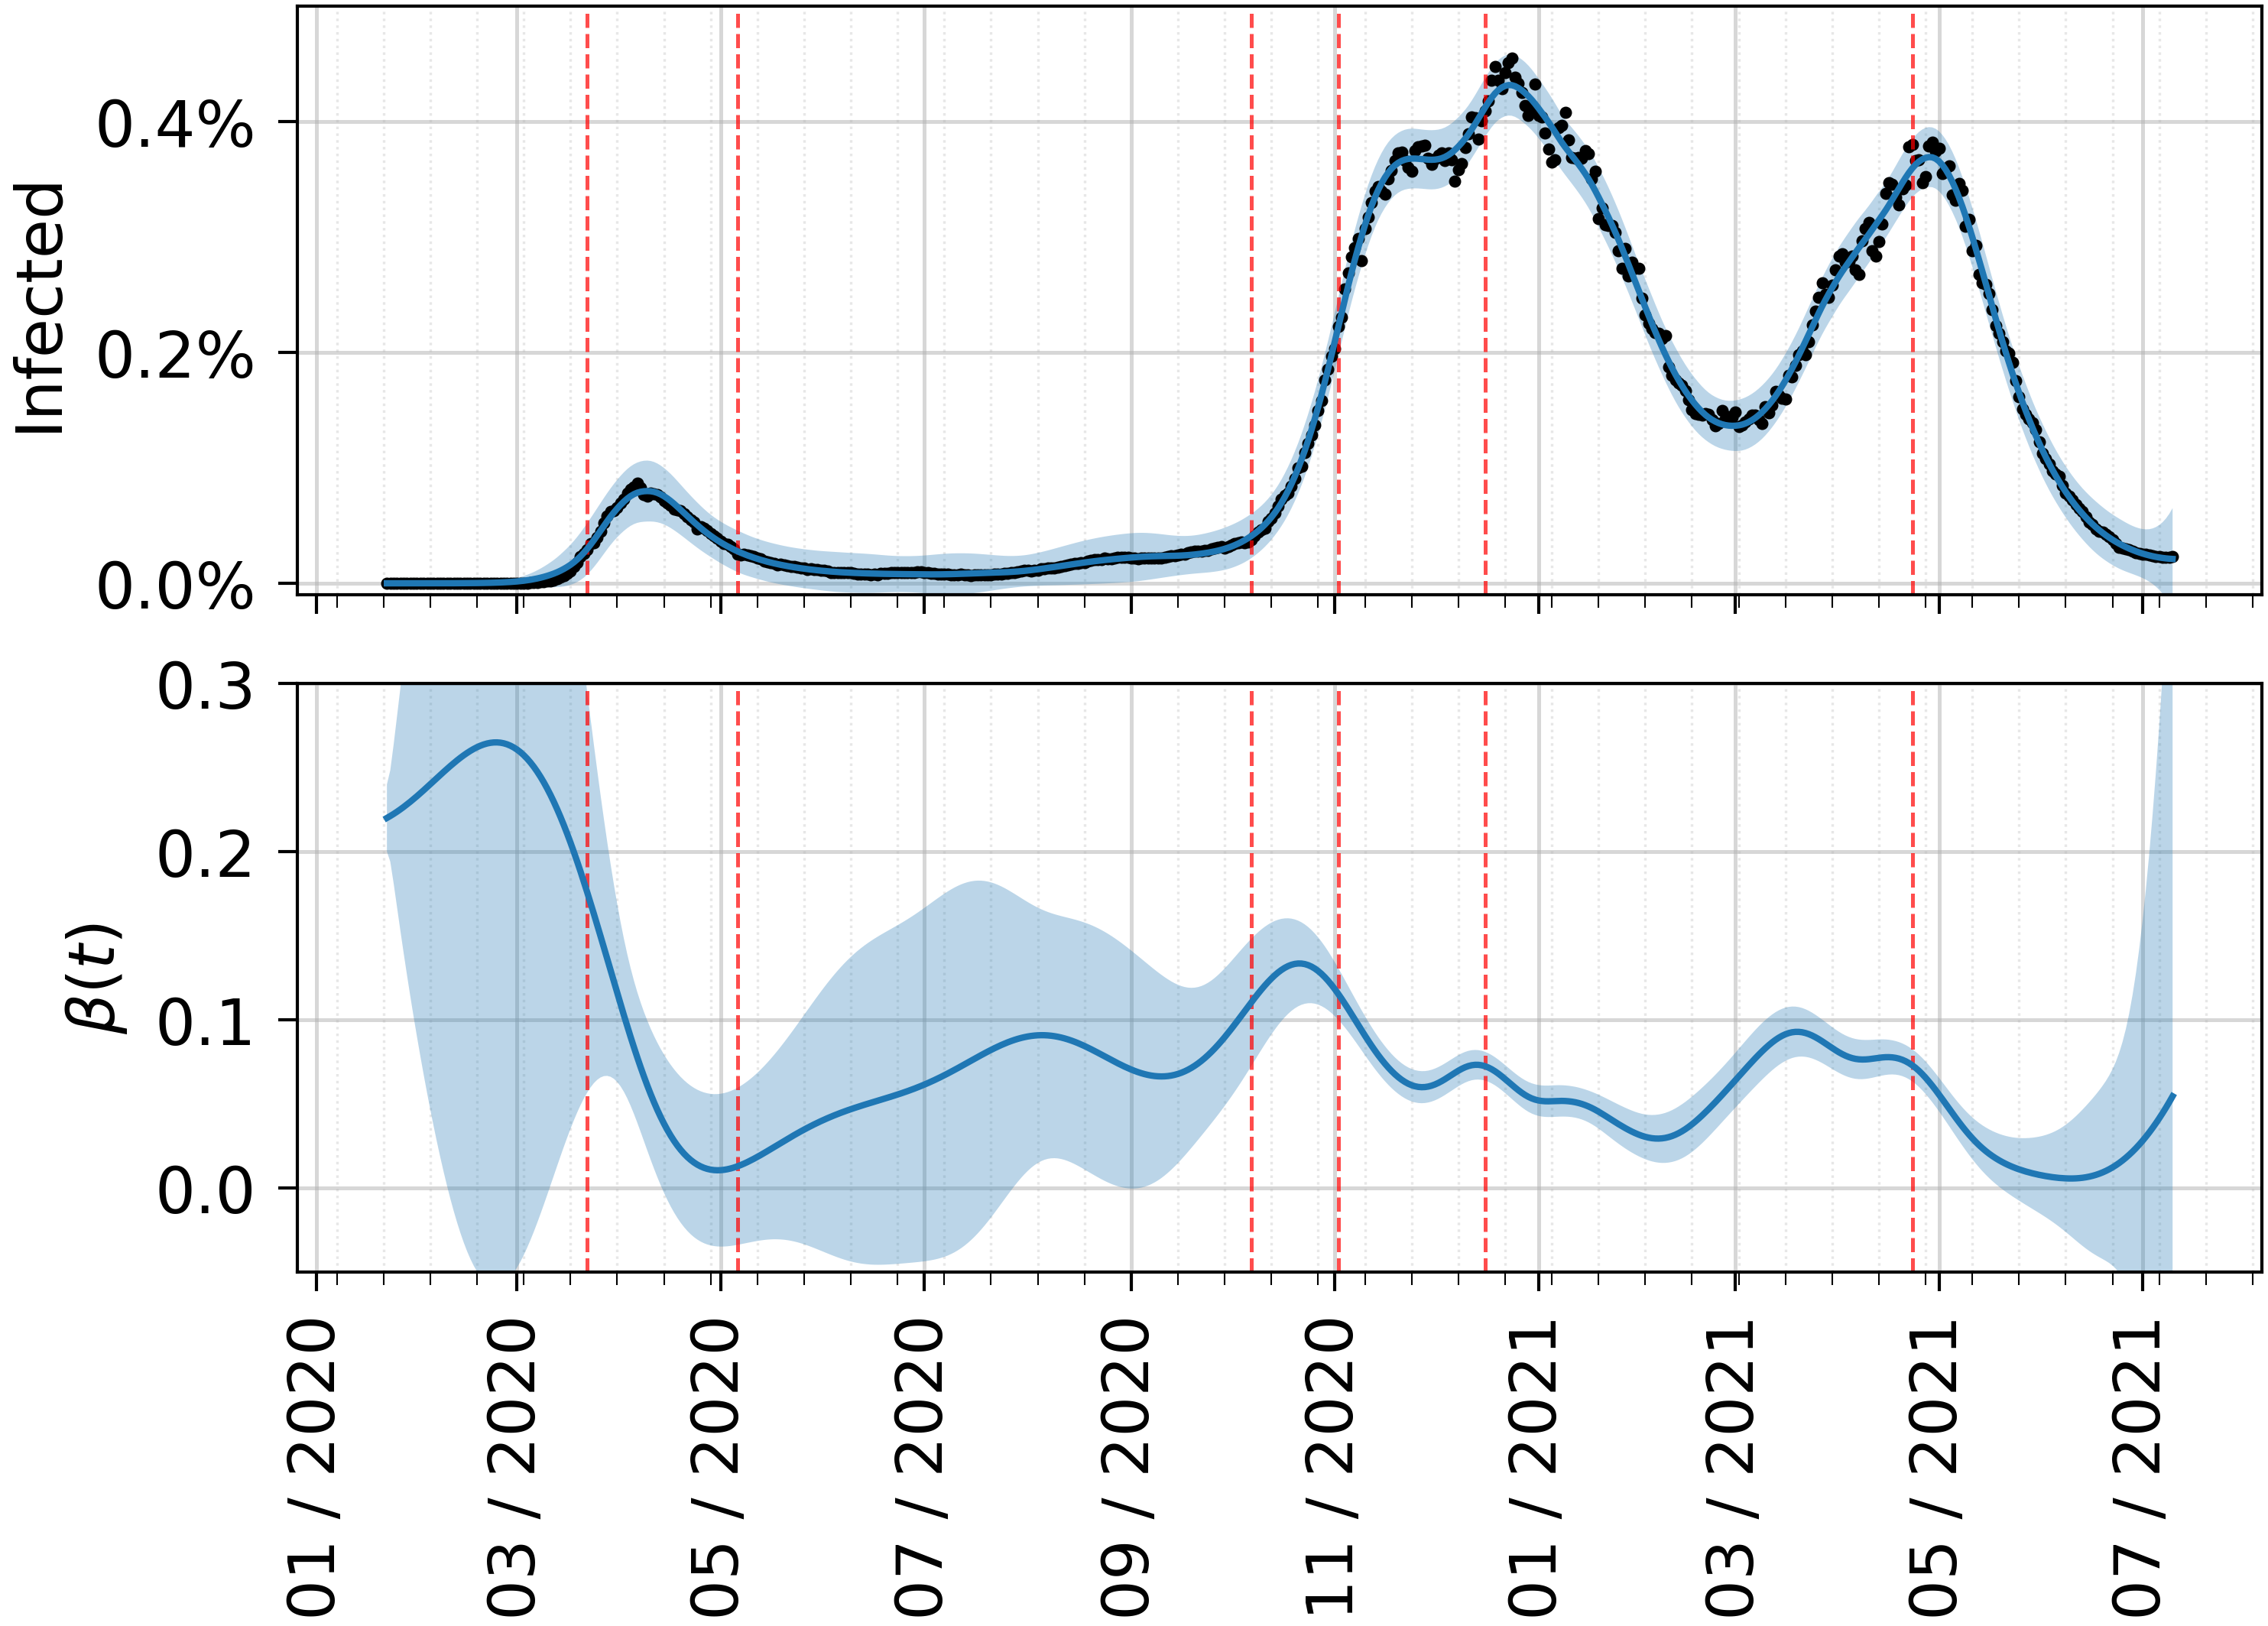

In [12]:
### Static plot (original)
fig, axs = plt.subplots(2, 1, figsize=(5, 3.6), sharex=True)

for ax, col, ylab, ylim in [
    (axs[0], 1, "Infected", [-0.0001, 0.005]),
    (axs[1], 3, r'$\beta(t)$', [-0.05, 0.3])
]:
    ax.plot(data_dates, m_sequence[:, col])
    P = P_sequence[:, col, col]
    margin = 2 * np.sqrt(P)
    ax.fill_between(data_dates, m_sequence[:, col]-margin, m_sequence[:, col]+margin, alpha=0.3)
    if col == 1:
        ax.scatter(data_dates, I, color='black', s=2)
    ax.set_ylabel(ylab)
    ax.set_ylim(ylim)
    # Add gridlines at major tick positions
    ax.grid(True, which='major', axis='both', linestyle='-', linewidth=0.6, alpha=0.5)
    # Add many intermediate vertical gridlines at minor tick positions (weekly)
    ax.xaxis.set_minor_locator(dates.WeekdayLocator(interval=2))
    ax.grid(True, which='minor', axis='x', linestyle=':', linewidth=0.4, alpha=0.3)

# Add political events as vertical lines to both subplots
for event_date in political_events:
    axs[0].axvline(event_date, color='red', linestyle='--', linewidth=0.6, alpha=0.7, zorder=1)
    axs[1].axvline(event_date, color='red', linestyle='--', linewidth=0.6, alpha=0.7, zorder=1)

axs[0].yaxis.set_major_formatter(
    plt.matplotlib.ticker.FuncFormatter(lambda x, _: f"{x*100:.1f}%")
)

axs[1].xaxis.set_tick_params(rotation=90, labelsize=plt.rcParams['xtick.labelsize'])
axs[1].xaxis.set_major_formatter(dates.DateFormatter("%m / %Y"))

plt.show()